In [2]:
import warnings
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection
import suncalc

import gim_tools
import datetime_tools as dt_extra

file_path = r'RADS\ASCII_files\c2_240212.asc'

warnings.filterwarnings('ignore', category=UserWarning)

In [56]:
def find_start_passes(file_path, verbose=True):
    # read the file, and determine the starting line of each pass
    with open(file_path, 'r') as f: lines = f.readlines()
    hashtag_lines = np.array([i for i, line in enumerate(lines) if '#' in line])
    diff = np.concatenate((np.array([30]), hashtag_lines[1:] - hashtag_lines[:-1]))
    start_pass_lines = hashtag_lines[diff > 1]

    if verbose:
        print(f'There are {len(start_pass_lines)} passes in ({file_path})')
    
    return start_pass_lines



def set_color(secs, cmap='Spectral'):
    cmap = plt.get_cmap(cmap)
    time_date = dt_extra.get_time_date(secs)
    
    date0 = gim_tools.split_time_date(time_date)[1]
    datef = gim_tools.get_next_day(date0)

    s0 = dt_extra.get_sec_since_1985(date0)
    sf = dt_extra.get_sec_since_1985(datef)

    return cmap((secs-s0)/(sf-s0))

def extract_pass(file_path, pass_n=None, start_pass_lines=None, plot=True, earth=Basemap(), **kwargs):
    
    if start_pass_lines is None:
        start_pass_lines = find_start_passes(file_path, verbose=False)

    if pass_n is None: # extract all passes
        skiprows = 0
        max_rows = None

        return extract_pass(file_path, np.arange(1, len(start_pass_lines)+1, 1), start_pass_lines, plot, earth, **kwargs)
    
    elif isinstance(pass_n, (list, np.ndarray)): # extract multiple passes
        assert len(set(pass_n)) == len(pass_n), 'There are repeated pass numbers!'

        secs_array = np.array([])
        lat_array = np.array([])
        lon_array = np.array([])
        sla_array = np.array([])

        for i, n in enumerate(pass_n):
            secs_i, lat_i, lon_i, sla_i = extract_pass(file_path, int(n), start_pass_lines, plot, earth, **kwargs)

            secs_array = np.append(secs_array, secs_i)
            lat_array = np.append(lat_array, lat_i)
            lon_array = np.append(lon_array, lon_i)
            sla_array = np.append(sla_array, sla_i)
        
        return secs_array, lat_array, lon_array, sla_array

    else: # extract only one pass
        assert pass_n <= len(start_pass_lines), 'There are not that many passes in this file!'
        assert pass_n >= 1

        if pass_n == len(start_pass_lines):
            skiprows = start_pass_lines[pass_n-1]
            max_rows  = None
        else:
            skiprows = start_pass_lines[pass_n-1]
            max_rows = start_pass_lines[pass_n] - start_pass_lines[pass_n-1]

    data = np.loadtxt(file_path, skiprows=skiprows, max_rows=max_rows)

    secs_array = data[:, 0]
    lat_array  = data[:, 1]
    lon_array  = data[:, 2]
    sla_array  = data[:, 3]

    if plot:
        color = set_color(np.average(secs_array))

        earth.scatter(lon_array, lat_array, s=20, c=color, marker='X', linewidths=0.01, label=f'avg. {convert_time(np.average(secs_array))}', zorder=1)
        ax = plt.gca()
        ax.legend(bbox_to_anchor=(1.06, 0.99), loc='upper left')
            
    return secs_array, lat_array, lon_array, sla_array

def plot_intensity_line(lon_array, lat_array, val_array, earth=Basemap(), **kwargs):
    # adapted from 'https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html'
    points = np.array([lon_array, lat_array]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(np.min(val_array), np.max(val_array))
    lc = LineCollection(segments, cmap='Spectral', norm=norm)
    # Set the values used for colormapping
    ax = plt.gca()
    lc.set_array(val_array)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
    earth.colorbar(line, size='2%', **kwargs)

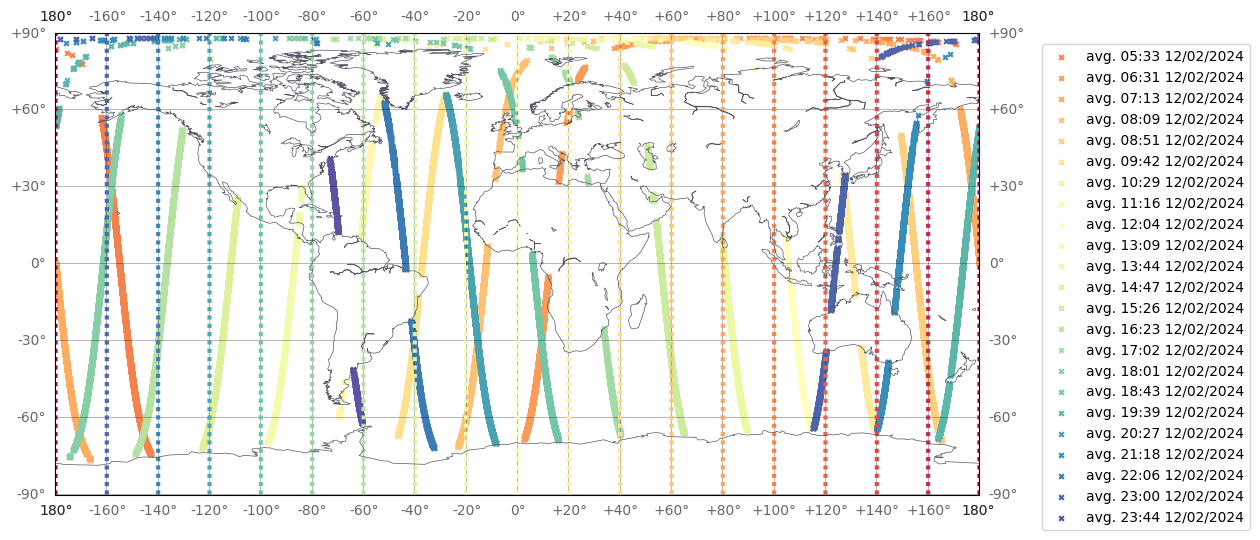

In [59]:
fig, ax = plt.subplots(figsize=(14,6))
earth=Basemap()
earth.drawcoastlines(color='#555566', linewidth=0.5, zorder=3)

cbar_pad = '8%'
grid_style = {'linewidth': 0.2, 'dashes':[1,0], 'labels':[1, 1, 1, 1], 'labelstyle':'+/-', 'alpha':0.6}
earth.drawmeridians(np.arange(-180, 181, 20), **grid_style)
earth.drawparallels(np.arange(-90, 91, 30), **grid_style)

a, b, c, d = extract_pass(file_path, pass_n=None, earth=earth)
# 

lon_arr = np.arange(-180, 180, 20)
lat_arr = np.zeros(lon_arr.shape)
height_arr = np.zeros(lon_arr.shape)
day = pd.to_datetime(lon_arr.size*['2024-02-12'])

df = pd.DataFrame({'date': day, 'lat': lat_arr, 'lon': lon_arr})

solar_noon = suncalc.get_times(df['date'], df['lon'], df['lat'])['solar_noon']

solar_noon_sec = [(time.to_pydatetime().replace(tzinfo=None)-datetime.datetime(1985, 1, 1)).total_seconds() for time in solar_noon.to_list()] # datetime.datetime.fromtimestamp(time).total_seconds()
colors = [set_color(sec) for sec in solar_noon_sec]

for lon, c in zip(lon_arr, colors):
    earth.drawmeridians(np.array([lon]), color=c, style='.-', linewidth=3)
